In [1]:
from Parameters import ModelParams
from Mass_Loss_Class import MassLoss
from Fractionation_Class import Fractionation
# from Fractionation_Class_H_O_CO2 import Fractionation_H_O_CO2
from Model_Data_Loader import ModelDataLoader
from Results_Handler import ResultsHandler
from Misc_Class import Misc
from Star_Parameters import StarParams

import numpy as np
import pandas as pd
import json

In [2]:
%matplotlib widget

Updated FEUV for TOI-431 b: 7.03e+04 erg cm-2 s-1

Processing group with Teq = 1862 K

 Running model with FEUV = 303.81674832213116 erg/cm^2/s
Converged in 2 iterations for planet 3.1 M_earth.
Final mmw_outflow = 1.0
Planet with mass=3.07 M_earth results: Mdot = 6658283.209205223
Planet with mass=3.07 M_earth results: phi_O = 1.7712611475071975e-83, phi_H = 6.830839990566376e-13, x_O = 5.186071259035111e-71


 Running model with FEUV = 841.7005869826477 erg/cm^2/s
Excluded: T_eq (1862.00 K) > T_outflow (1785.94 K) for planet mass=3.07 M_earth.

 Running model with FEUV = 2331.8657777739354 erg/cm^2/s
Converged in 2 iterations for planet 3.1 M_earth.
Final mmw_outflow = 1.0
Planet with mass=3.07 M_earth results: Mdot = 318032850.1902968
Planet with mass=3.07 M_earth results: phi_O = 3.4588739358573447e-62, phi_H = 3.1842420759955784e-11, x_O = 2.172494335108552e-51


 Running model with FEUV = 6460.2521248631865 erg/cm^2/s
Converged in 2 iterations for planet 3.1 M_earth.
Final mmw_out

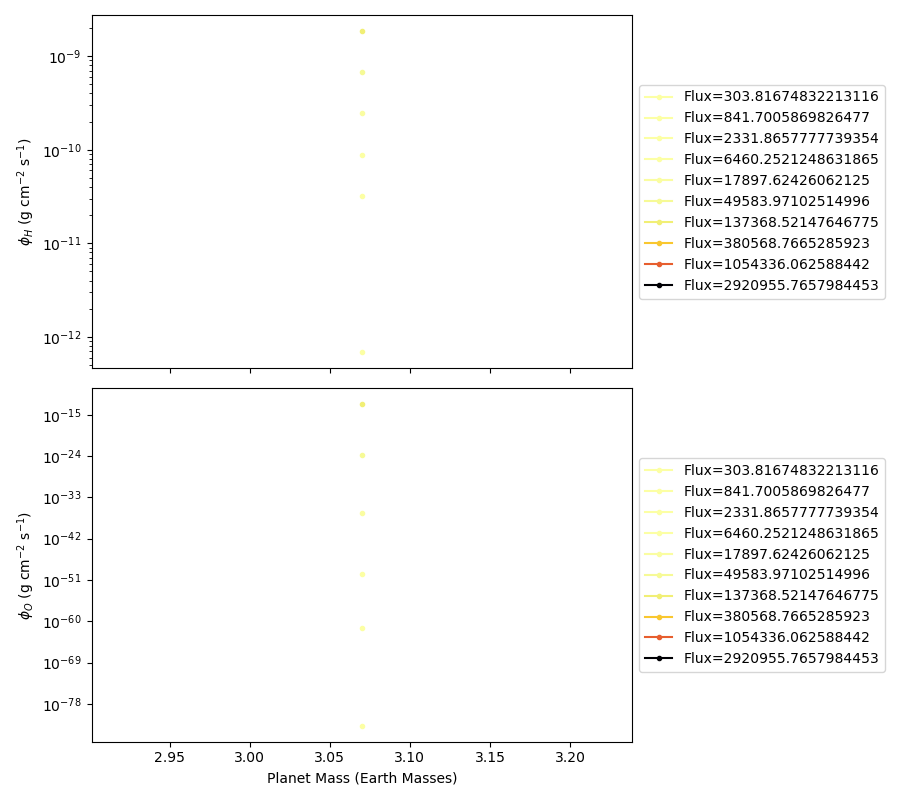

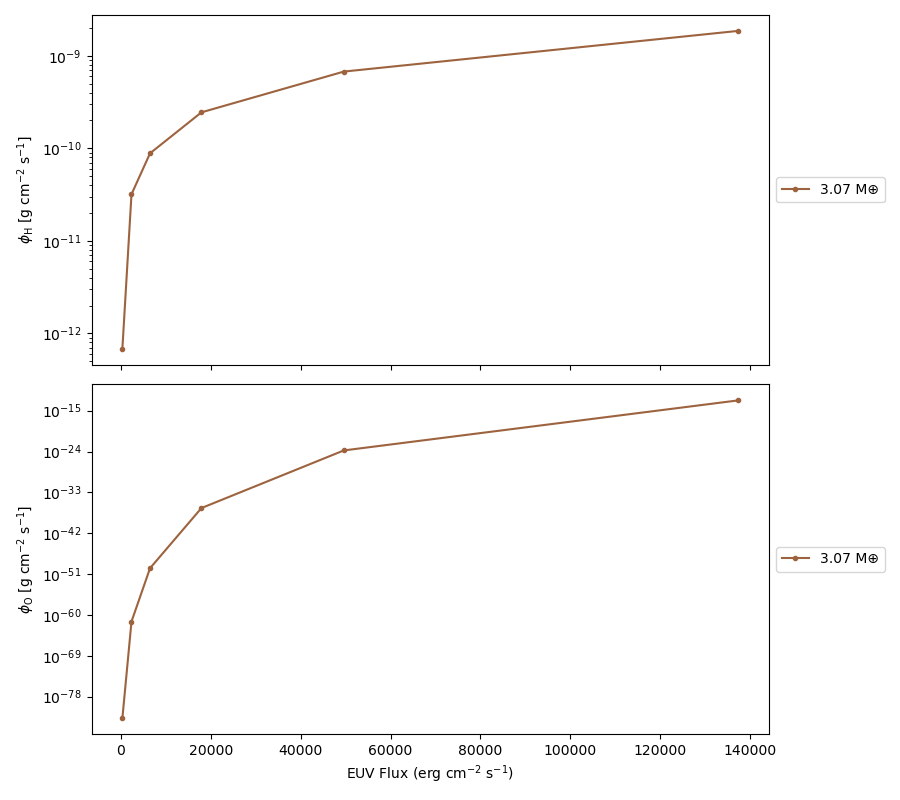

In [5]:
# def main():

# ---------- Initialize parameters and classes ----------
params = ModelParams()
mass_loss = MassLoss(params)
fractionation = Fractionation(params)
# fractionation_multi = Fractionation_H_O_CO2(params)
misc = Misc(params)
# loader = ModelDataLoader('/Users/mvalatsou/PhD/Repos/MR_perplex/OUTPUT/', params)
star_params = StarParams(params)

# ---------- Load data ----------
### option 1
# mass, radius, Teq = loader.load_single_ddat_file('3HHe_subNeptune.ddat')
# unique_Teqs = np.unique(Teq)
# print("Unique Teq values found:", unique_Teqs)

### option 2
# r_m_T = loader.load_all_ddat_files()
# Convert units from the r_m_T dictionary to cgs

### option 3
# radius = 1 # cm
# mass = 1 # g
# Teq = 1 # K

# ## option 4
with open("planet_params.json", "r") as file:
    planet_params = json.load(file)
selected_planet = "TOI-431 b" # change the planet here

if selected_planet in planet_params:
    new_feuv = planet_params[selected_planet]["FEUV"]
    params.update_param("FEUV", new_feuv)
    print(f"Updated FEUV for {selected_planet}: {params.get_param('FEUV'):.2e} erg cm-2 s-1")
else:
    print(f"Make sure the planet you selected exists in the list! Check the spelling.")

mearth = params.mearth
rearth = params.rearth
radius = np.array([planet_params[selected_planet]["radius"] * rearth]) # cm
mass = np.array([planet_params[selected_planet]["mass"] * mearth]) # g
Teq = np.array([planet_params[selected_planet]["teq"]]) # K
unique_Teqs = np.unique(Teq)

# ---------- Range of EUV flux values ----------
all_flux_results = []

### option 1, manually set values
# flux_range = [100, 450, 800, 1000, 5000]

# ## option 2, scan parameter space
# start_log = np.log10(100)   # 2
# stop_log  = np.log10(10000) # 4
# step      = 0.25
# log_vals  = np.arange(start_log, stop_log + step, step)
# flux_range = 10 ** log_vals

# ## option 3, scan parameter space
# flux_range = np.logspace(np.log10(100), np.log10(10000), 10)

# ## option 4, if planet is selected from .json file
# flux_range = [params.get_param("FEUV")]

### option 5 
for Teq_val in unique_Teqs:
    star_params.update_param("Teq", Teq_val)
    flux_range = star_params.get_FEUV_range_any_age()
    # flux_range = misc.get_flux_range(Teq_val)

    mask = np.isclose(Teq, Teq_val)
    mass_group = mass[mask]
    radius_group = radius[mask]
    teq_group = Teq[mask]
    print(f"\nProcessing group with Teq = {Teq_val} K")

    # ---------- Execute ----------
    for flux in flux_range:
        print(f"\n Running model with FEUV = {flux} erg/cm^2/s")
        params.update_param('FEUV', flux)

        # ---------- Mass loss model ----------
        mass_loss_results = mass_loss.compute_mass_loss_parameters(mass_group, radius_group, teq_group)
        # mdot = mass_loss_results[0]['Mdot']
        # print(f"Mdot =", mdot)

        results_for_this_flux = {'FEUV': flux, 'Teq': Teq_val, 'end_results': mass_loss_results}
        
        # ---------- Fractionation model ----------
        ### option 1 - without self consistent feedback loop
        # fractionation_results = fractionation.execute_fractionation(mass_loss_results, misc)
        
        ### option 2 - with feedback loop
        fractionation_results = fractionation.execute_self_consistent_fractionation(mass_loss_results, mass_loss, misc, params)

        ### option 3 - for H O CO2 system, with feedback loop (?)
        # fractionation_results = fractionation_multi.execute_self_consistent_fractionation(mass_loss_results, mass_loss, misc, params)

        results_for_this_flux = {'FEUV': flux, 'Teq': Teq_val, 'end_results': fractionation_results}
        
        all_flux_results.append(results_for_this_flux)


# rows = []

# for flux_data in all_flux_results:
#     flux = flux_data['FEUV']
#     for res in flux_data['end_results']:
#         record = {'FEUV': flux}
#         record.update(res)
#         rows.append(record)

# df = pd.DataFrame(rows)
# df.to_csv('OUTPUT/3HHe_subNeptune.csv', index=False)
#df.to_csv('/Users/mvalatsou/PhD/Repos/MR_perplex/OUTPUT/3HHe_subNeptune.csv', index=False)

# # ---------- Plot ----------
# # Across all EUV fluxes
# ResultsHandler.plot_regime_scatter(all_flux_results)
ResultsHandler.plot_phi_vs_m_planet_across_fluxes(all_flux_results)
ResultsHandler.plot_phi_vs_flux_across_masses(all_flux_results)
# ResultsHandler.plot_mmw_vs_flux_across_masses(all_flux_results)
# ResultsHandler.plot_mmw_vs_masses_across_fluxes(all_flux_results)

# # Single EUV flux value results
# single_flux_data = all_flux_results[0] # pick a flux
# single_results_list = single_flux_data['fractionation_results']

# ResultsHandler.plot_radii_comparison(single_results_list)
# ResultsHandler.plot_cs_REUV(single_results_list)
# ResultsHandler.plot_combined_T_P(single_results_list)
# ResultsHandler.plot_phiH_phiO_vs_REUV(single_results_list)
# ResultsHandler.water_loss_over_time(single_results_list)

# if __name__ == "__main__":
#    main()

In [ ]:
df_superEarth = pd.read_csv('/path/to/3H2O_superEarth.csv')
df_subNeptune = pd.read_csv('/path/to/3HHe_subNeptune.csv')
# df_subNeptune_H2O = pd.read_csv('/path/to/3HHe_10H2O_subNeptune.csv')

df_superEarth["planet_type"] = "3H2O_superEarth"
df_subNeptune["planet_type"] = "3HHe_subNeptune"
# df_subNeptune_H2O["planet_type"] = "3HHe_10H2O_subNeptune"

df_combined = pd.concat([df_superEarth, df_subNeptune], ignore_index=True) # combine dfs

ResultsHandler.plot_Mdot_vs_m_planet(df_combined) # plot combined dfs